In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (Flatten, Dense, BatchNormalization, Activation, Concatenate)
from tensorflow.keras import backend as K
from matplotlib.ticker import FuncFormatter

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    # tf.config.experimental.set_virtual_device_configuration(gpu_devices[0],
    # [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
else:
    print('Using CPU')

sns.set_style('whitegrid')
data_path = Path('data', 'image', 'svhn')

results_path = Path('results', 'svhn')
if not results_path.exists():
    results_path.mkdir()

Using CPU


In [3]:
# Settings
IMG_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
SEQ_LENGTH = 4
N_CLASSES = 11

# Load Data
X_train = np.load(data_path / 'X_train.npy')
y_train = np.load(data_path / 'y_train.npy')

In [4]:
X_train = X_train[y_train[:, 0] < 5]
y_train = y_train[y_train[:, 0] < 5, :5]
y_train[:, 0] -= 1
X_test = np.load(data_path / 'X_test.npy')
y_test = np.load(data_path / 'y_test.npy')
X_test = X_test[y_test[:, 0] < 5]
y_test = y_test[y_test[:, 0] < 5, :5]
y_test[:, 0] -= 1
pd.DataFrame(y_train).nunique()

0     4
1    10
2    11
3    11
4    11
dtype: int64

In [5]:
y_train.shape

(33392, 5)

In [6]:
# Best Architecture
digit_pos = {1: [4, 14], 2: [14, 25], 3: [25, 36], 4: [36, 47]}

def weighted_accuracy(y_true, y_pred):
    n_digits_pred = K.argmax(y_pred[:, :SEQ_LENGTH], axis=1)

    digit_preds = {}
    for digit, (start, end) in digit_pos.items():
        digit_preds[digit] = K.argmax(y_pred[:, start:end], axis=1)
    preds = tf.dtypes.cast(tf.stack((n_digits_pred, digit_preds[1], digit_preds[2], digit_preds[3],
                                     digit_preds[4]), axis=1), tf.float32)

    return K.mean(K.sum(tf.dtypes.cast(K.equal(y_true, preds), tf.int64), axis=1) / 5)

def weighted_entropy(y_true, y_pred):
    cce = tf.keras.losses.SparseCategoricalCrossentropy()
    n_digits = y_pred[:, :SEQ_LENGTH]

    digits = {}
    for digit, (start, end) in digit_pos.items():
        digits[digit] = y_pred[:, start:end]
    return (cce(y_true[:, 0], n_digits) + cce(y_true[:, 1], digits[1]) + cce(y_true[:, 2], digits[2]) +
            cce(y_true[:, 3], digits[3]) + cce(y_true[:, 4], digits[4])) / 5

In [7]:
vgg16 = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
vgg16.trainable = False
x = vgg16.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
n_digits = Dense(SEQ_LENGTH, activation='softmax', name='n_digits')(x)
digit1 = Dense(N_CLASSES-1, activation='softmax', name='d1')(x)
digit2 = Dense(N_CLASSES, activation='softmax', name='d2')(x)
digit3 = Dense(N_CLASSES, activation='softmax', name='d3')(x)
digit4 = Dense(N_CLASSES, activation='softmax', name='d4')(x)
predictions = Concatenate()([n_digits, digit1, digit2, digit3, digit4])

model = Model(inputs=vgg16.input, outputs=predictions)
model.compile(optimizer='adam', loss=weighted_entropy, metrics=[weighted_accuracy])

In [8]:
# Define Callbacks
svhn_path = (results_path / 'svhn.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=svhn_path, verbose=1, monitor='val_weighted_accuracy',
                               save_best_only=True)
early_stopping = EarlyStopping(monitor='val_weighted_accuracy', patience=5)

In [9]:
# Train Transfer Model
epochs = 50
result = model.fit(x=X_train, y=y_train, validation_split=.1, batch_size=32, epochs=epochs, verbose=1,
                    callbacks=[checkpointer, early_stopping], workers=6)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (

In [10]:
# Evaluate Results
metrics = pd.DataFrame(result.history)
initial_epochs = len(metrics)
y_pred = model.predict(X_test, verbose=1)

409/409 [==============================] - 99s 241ms/step


In [11]:
n_digits = y_pred[:, :SEQ_LENGTH]
digits = {}
for digit, (start, end) in digit_pos.items():
    digits[digit] = y_pred[:, start:end]

(y_test[:, 0] == np.argmax(n_digits, axis=1)).sum()/len(n_digits)

0.19003520587785092

In [12]:
confusion_matrix(y_true=y_test[:, 0], y_pred=np.argmax(n_digits, axis=1))

array([[2483,    0,    0,    0],
       [8356,    0,    0,    0],
       [2081,    0,    0,    0],
       [ 146,    0,    0,    0]], dtype=int64)

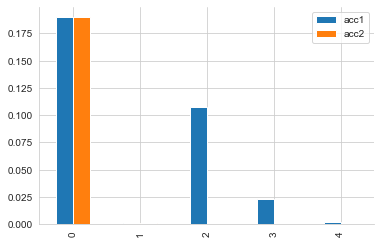

In [13]:
accuracy = np.zeros_like(y_test)
accuracy[:, 0] = (y_test[:, 0] == np.argmax(n_digits, axis=1))

for i in range(1, 5):
    accuracy[:, i] = (y_test[:, i] == np.argmax(digits[i], axis=1))

acc_by_output = {}
for i in range(5):
    acc_by_output[i] = accuracy[:, i].sum()/accuracy[:, i].shape[0]

acc_up_to_out = {}
for i in range(1, 6):
    r = accuracy[:, :i].all(1)
    acc_up_to_out[i-1] = r.sum()/r.shape[0]

pd.DataFrame({'acc1': acc_by_output, 'acc2': acc_up_to_out}).plot.bar()
sns.despine();

In [14]:
result.history

{'loss': [nan, nan, nan, nan, nan, nan],
 'weighted_accuracy': [0.06807181239128113,
  0.0605585090816021,
  0.060512006282806396,
  0.060511961579322815,
  0.060558516532182693,
  0.06051196530461311],
 'val_loss': [nan, nan, nan, nan, nan, nan],
 'val_weighted_accuracy': [0.05924604833126068,
  0.05924604833126068,
  0.05924604833126068,
  0.05924604833126068,
  0.05924604833126068,
  0.05924604833126068]}

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 32, 32, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 16, 16, 64)   0           block1_conv2[0][0]               
_______________________________________________________________________________________

In [16]:
len(model.trainable_variables)

20

In [ ]:
# # Fine Tune VGG16 weights
# vgg16.trainable = True
# # Fine-tune from this layer onwards
# start_fine_tuning_at = 1
# 
# # Freeze all the layers before the `fine_tune_at` layer
# for layer in vgg16.layers[:start_fine_tuning_at]:
#     layer.trainable =  False
# 
# model.compile(optimizer='adam', loss=weighted_entropy, metrics=[weighted_accuracy])
# 
# fine_tune_epochs = 50
# total_epochs = initial_epochs + fine_tune_epochs
# 
# result_fine_tune = model.fit(x=X_train, y=y_train, validation_split=.1, batch_size=32, epochs=total_epochs, initial_epoch=initial_epochs, callbacks=[early_stopping], workers=6)

Epoch 7/56


In [ ]:
# metrics_tuned = metrics.append(pd.DataFrame(result_fine_tune.history), ignore_index=True)
# metrics_tuned.info()

In [ ]:
# fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
# metrics_tuned[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy Loss')
# metrics_tuned[['weighted_accuracy', 'val_weighted_accuracy']].plot(ax=axes[0], title=f'Accuracy (Best: {metrics_tuned.val_weighted_accuracy.max():.2%})')
# axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
# axes[0].set_ylabel('Accuracy')
# axes[1].set_ylabel('Loss')
# 
# for ax in axes:
#     ax.axvline(14, ls='--', lw=1, c='k')
#     ax.legend(['Training', 'Validation', 'Start Fine Tuning'])
#     ax.set_xlabel('Epoch')
# 
# fig.tight_layout()
# fig.savefig(results_path / 'transfer_learning_svhn');